## Import, common routines and dataset

In [3]:
import sys
sys.path.append('/home/egor/cvx_repo/ddn/ddn')

In [4]:
import numpy as np

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torchattacks

import ddn.pytorch.robustpool as robustpool

import neptune

import urllib
from urllib.request import urlretrieve
from pathlib import Path

# import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from IPython.display import clear_output


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [5]:
DATASET_ROOT = Path("Architectural_Heritage_Elements_Dataset_128_splitted")
ARCHIVE_NAME = Path("Architectural_Heritage_Elements_Dataset_128_splitted.zip")

N_CLASSES = 10

if not ARCHIVE_NAME.is_file():
    print("Downloading...")
    urlretrieve(
        "https://dl.dropboxusercontent.com/s/bucvr9x6ypqjht2/Architectural_Heritage_Elements_Dataset_128_splitted.zip",
        ARCHIVE_NAME)

if not DATASET_ROOT.is_dir():
    print("Unzipping...")
    import zipfile
    with zipfile.ZipFile(ARCHIVE_NAME, 'r') as archive:
        archive.extractall(".")

train_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / "train", transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / "test", transform=transforms.ToTensor())

Downloading...


In [6]:
def calculate_accuracy(model, batches):
    n_predictions = 0
    n_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in batches:
            y_pred = torch.argmax(model.forward(X_batch.to(DEVICE)), dim=1).cpu()
            n_correct += (y_pred == y_batch).sum().item()
            n_predictions += y_batch.shape[0]
    
    return n_correct / n_predictions


def calculate_accuracy_dataset(model, dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    return calculate_accuracy(model, loader)


def run_epoch(model, optimizer, criterion, batches, phase='train'):
    is_train = phase == 'train'
    if is_train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    n_predictions = 0

    for X_batch, y_batch in batches:

        with torch.set_grad_enabled(is_train):
            y_pred = model.forward(X_batch.to(DEVICE))
            loss = criterion.forward(y_pred, y_batch.to(DEVICE))
    
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item() * y_batch.shape[0]
        n_predictions += y_batch.shape[0]

    epoch_loss = epoch_loss / n_predictions

    return epoch_loss


def train_model(model, optimizer, criterion, n_epoch, batch_size, dataset, train_percentage, backup_name):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf

    # train_batches, val_batches = get_train_val_loaders(train_dataset, val_dataset, batch_size=batch_size)
    train_len = int(len(dataset) * train_percentage)
    val_len = len(dataset) - train_len
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
    
    train_batches = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    val_batches = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

    for epoch in range(n_epoch):
        train_loss = run_epoch(model, optimizer, criterion, train_batches, phase='train')
        val_loss = run_epoch(model, optimizer, criterion, val_batches, phase='val')

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), backup_name)

        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.title("Train and validation loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show()

## ResNet-18

In [42]:
model = model = torchvision.models.resnet18(pretrained=False, num_classes=N_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

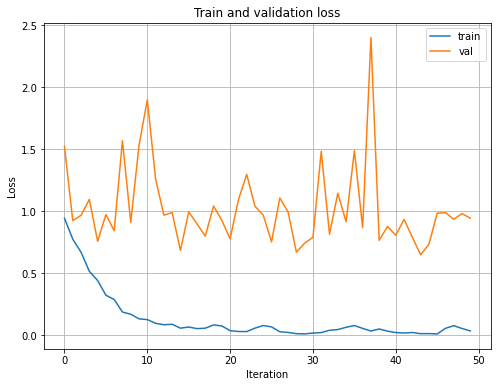

In [44]:
train_model(model, optimizer, 
            criterion=nn.CrossEntropyLoss(),
            n_epoch=50,
            batch_size=128,
            dataset=train_dataset,
            train_percentage=0.7,
            backup_name="resnet18_basic.pth.tar")

In [45]:
best_model = torchvision.models.resnet18(pretrained=False, num_classes=N_CLASSES)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("resnet18_basic.pth.tar"))
best_model = best_model.eval()

In [46]:
calculate_accuracy_dataset(best_model, test_dataset, 128)

0.8327645051194539

## Adversarial attacks

In [12]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test_attack(model, test_dataset, epsilon):
    # Accuracy counter
    correct = 0
    
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=4, shuffle=False)

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc

In [47]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [48]:
standard_model_accs = []
for epsilon in epsilons:
    acc = test_attack(best_model, test_dataset, epsilon)
    standard_model_accs.append(acc)
print(standard_model_accs)

Epsilon: 0	Test Accuracy = 1708 / 2051 = 0.8327645051194539
Epsilon: 0.05	Test Accuracy = 26 / 2051 = 0.012676743052169674
Epsilon: 0.1	Test Accuracy = 0 / 2051 = 0.0
Epsilon: 0.15	Test Accuracy = 1 / 2051 = 0.00048756704046806434
Epsilon: 0.2	Test Accuracy = 1 / 2051 = 0.00048756704046806434
Epsilon: 0.25	Test Accuracy = 14 / 2051 = 0.006825938566552901
Epsilon: 0.3	Test Accuracy = 33 / 2051 = 0.016089712335446125
[0.8327645051194539, 0.012676743052169674, 0.0, 0.00048756704046806434, 0.00048756704046806434, 0.006825938566552901, 0.016089712335446125]


## Robust pooling

In [51]:
class RobustPoolResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self._model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
        self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.Welsch)
    
    def forward(self, x):
        return self._model.forward(x)

In [ ]:
class RobustPoolResNet(nn.Module):
    def __init__(self, num_classes, robust_type, alpha=1.0):
        super().__init__()
        
        if robust_type != "vanilla":
            self._model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
            self._model_name = "resnet18"

            if robust_type == "quadratic":
                self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.Quadratic, alpha=alpha)
                self._model_name += "quadratic" # + str(alpha).replace('.', '_')
            elif robust_type == "huber":
                self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.Huber, alpha=alpha)
                self._model_name += "huber"
            elif robust_type == "pseudo-huber":
                self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.PseudoHuber, alpha=alpha)
                self._model_name += "pseudo_huber"
            elif robust_type == "welsch":
                self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.Welsch, alpha=alpha)
                self._model_name += "welsch"
            elif robust_type == "trunc-quadratic":
                self._model.avgpool = robustpool.RobustGlobalPool2d(robustpool.TruncatedQuadratic, alpha=alpha)
                self._model_name += "trunc_quadratic"

            self._model_name += "_alpha_" + str(alpha).replace('.', '_')

        else:
            self._model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
            self._model_name = "resnet18_vanilla"
    
    def forward(self, x):
        return self._model.forward(x)

    def get_model_name(self):
        return self._model_name


In [52]:
model = RobustPoolResNet(num_classes=N_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

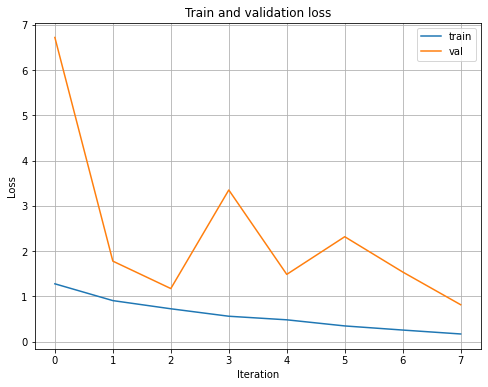

In [ ]:
train_model(model, optimizer, 
            criterion=nn.CrossEntropyLoss(),
            n_epoch=50,
            batch_size=256,
            dataset=train_dataset,
            train_percentage=0.7,
            backup_name="resnet18_welsch.pth.tar")

In [24]:
best_model = RobustPoolResNet(num_classes=N_CLASSES)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("resnet18_welsch.pth.tar"))
best_model = best_model.eval()

In [25]:
robust_model_accs = []
for epsilon in epsilons:
    acc = test_attack(best_model, test_dataset, epsilon)
    robust_model_accs.append(acc)
print(robust_model_accs)

KeyboardInterrupt: 

In [64]:
frac_standard = np.array(standard_model_accs) / standard_model_accs[0]
frac_robust = np.array(robust_model_accs) / robust_model_accs[0]

In [65]:
plt.plot(epsilons, frac_standard, label="Basic")
plt.plot(epsilons, frac_robust, label="Robust")
plt.legend()
plt.show()

## torchattacks

In [26]:
#     n_predictions = 0
#     n_correct = 0

#     with torch.no_grad():
#         for X_batch, y_batch in batches:
#             y_pred = torch.argmax(model.forward(X_batch.to(DEVICE)), dim=1).cpu()
#             n_correct += (y_pred == y_batch).sum().item()
#             n_predictions += y_batch.shape[0]
    
#     return n_correct / n_predictions


def test_attack_torchattack(model, dataset, epsilon, batch_size):
    attack = torchattacks.FGSM(model, eps=epsilon)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    
    n_correct = 0
    n_predictions = 0
    
    for image_batch, label_batch in loader:
        
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        adversarial_images = attack(image_batch, label_batch)
        
        with torch.no_grad():
            y_pred = torch.argmax(model.forward(adversarial_images), dim=1)
            n_correct += (y_pred == label_batch).sum().item()
            n_predictions += label_batch.shape[0]
            
    return n_correct / n_predictions

def test_attack_torchattack(model, dataset, epsilon, batch_size):
    attack = torchattacks.FGSM(model, eps=epsilon)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    
    n_correct = 0
    n_predictions = 0
    
    for image_batch, label_batch in loader:
        
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        adversarial_images = attack(image_batch, label_batch)
        
        with torch.no_grad():
            y_pred = torch.argmax(model.forward(adversarial_images), dim=1)
            n_correct += (y_pred == label_batch).sum().item()
            n_predictions += label_batch.shape[0]
            
    return n_correct / n_predictions

def test_attack_gn(model, dataset, epsilon, batch_size):
    attack = torchattacks.GN(model)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    
    n_correct = 0
    n_predictions = 0
    
    for image_batch, label_batch in loader:
        
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        adversarial_images = attack(image_batch, label_batch)
        
        with torch.no_grad():
            y_pred = torch.argmax(model.forward(adversarial_images), dim=1)
            n_correct += (y_pred == label_batch).sum().item()
            n_predictions += label_batch.shape[0]
            
    return n_correct / n_predictions

In [27]:
best_model = RobustPoolResNet(num_classes=N_CLASSES)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("resnet34_pseudo_welsch.pth.tar"))
best_model = best_model.eval()

In [28]:
test_attack_torchattack(best_model, test_dataset, epsilon=0.0, batch_size=128)

0.8210628961482204

In [29]:
calculate_accuracy_dataset(best_model, test_dataset, 128)

0.8210628961482204

## torchattacks: evaluation

In [30]:
epsilons = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

In [39]:
best_model = torchvision.models.resnet34(pretrained=False, num_classes=N_CLASSES)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("resnet34_basic.pth.tar"))
best_model = best_model.eval()

basic_model_accs = []
for epsilon in epsilons:
    acc = test_attack_torchattack(best_model, test_dataset, epsilon=epsilon, batch_size=128)
    basic_model_accs.append(acc)
basic_model_accs = np.array(basic_model_accs)

In [63]:
basic_model_accs

array([0.7766943 , 0.02242808, 0.00975134, 0.01121404, 0.03217942,
       0.06533398, 0.08824963])

In [65]:
robust_model_accs = np.array(robust_model_accs)

In [62]:
best_model = RobustPoolResNet(num_classes=N_CLASSES)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("resnet34_pseudo_welsch.pth.tar"))
best_model = best_model.eval()

robust_model_accs = []
for epsilon in epsilons:
    acc = test_attack_torchattack(best_model, test_dataset, epsilon=epsilon, batch_size=128)
    robust_model_accs.append(acc)
robust_model_accs = np.array(robust_model_accs)

RuntimeError: Error(s) in loading state_dict for RobustPoolResNet:
	Unexpected key(s) in state_dict: "_model.layer1.2.conv1.weight", "_model.layer1.2.bn1.weight", "_model.layer1.2.bn1.bias", "_model.layer1.2.bn1.running_mean", "_model.layer1.2.bn1.running_var", "_model.layer1.2.bn1.num_batches_tracked", "_model.layer1.2.conv2.weight", "_model.layer1.2.bn2.weight", "_model.layer1.2.bn2.bias", "_model.layer1.2.bn2.running_mean", "_model.layer1.2.bn2.running_var", "_model.layer1.2.bn2.num_batches_tracked", "_model.layer2.2.conv1.weight", "_model.layer2.2.bn1.weight", "_model.layer2.2.bn1.bias", "_model.layer2.2.bn1.running_mean", "_model.layer2.2.bn1.running_var", "_model.layer2.2.bn1.num_batches_tracked", "_model.layer2.2.conv2.weight", "_model.layer2.2.bn2.weight", "_model.layer2.2.bn2.bias", "_model.layer2.2.bn2.running_mean", "_model.layer2.2.bn2.running_var", "_model.layer2.2.bn2.num_batches_tracked", "_model.layer2.3.conv1.weight", "_model.layer2.3.bn1.weight", "_model.layer2.3.bn1.bias", "_model.layer2.3.bn1.running_mean", "_model.layer2.3.bn1.running_var", "_model.layer2.3.bn1.num_batches_tracked", "_model.layer2.3.conv2.weight", "_model.layer2.3.bn2.weight", "_model.layer2.3.bn2.bias", "_model.layer2.3.bn2.running_mean", "_model.layer2.3.bn2.running_var", "_model.layer2.3.bn2.num_batches_tracked", "_model.layer3.2.conv1.weight", "_model.layer3.2.bn1.weight", "_model.layer3.2.bn1.bias", "_model.layer3.2.bn1.running_mean", "_model.layer3.2.bn1.running_var", "_model.layer3.2.bn1.num_batches_tracked", "_model.layer3.2.conv2.weight", "_model.layer3.2.bn2.weight", "_model.layer3.2.bn2.bias", "_model.layer3.2.bn2.running_mean", "_model.layer3.2.bn2.running_var", "_model.layer3.2.bn2.num_batches_tracked", "_model.layer3.3.conv1.weight", "_model.layer3.3.bn1.weight", "_model.layer3.3.bn1.bias", "_model.layer3.3.bn1.running_mean", "_model.layer3.3.bn1.running_var", "_model.layer3.3.bn1.num_batches_tracked", "_model.layer3.3.conv2.weight", "_model.layer3.3.bn2.weight", "_model.layer3.3.bn2.bias", "_model.layer3.3.bn2.running_mean", "_model.layer3.3.bn2.running_var", "_model.layer3.3.bn2.num_batches_tracked", "_model.layer3.4.conv1.weight", "_model.layer3.4.bn1.weight", "_model.layer3.4.bn1.bias", "_model.layer3.4.bn1.running_mean", "_model.layer3.4.bn1.running_var", "_model.layer3.4.bn1.num_batches_tracked", "_model.layer3.4.conv2.weight", "_model.layer3.4.bn2.weight", "_model.layer3.4.bn2.bias", "_model.layer3.4.bn2.running_mean", "_model.layer3.4.bn2.running_var", "_model.layer3.4.bn2.num_batches_tracked", "_model.layer3.5.conv1.weight", "_model.layer3.5.bn1.weight", "_model.layer3.5.bn1.bias", "_model.layer3.5.bn1.running_mean", "_model.layer3.5.bn1.running_var", "_model.layer3.5.bn1.num_batches_tracked", "_model.layer3.5.conv2.weight", "_model.layer3.5.bn2.weight", "_model.layer3.5.bn2.bias", "_model.layer3.5.bn2.running_mean", "_model.layer3.5.bn2.running_var", "_model.layer3.5.bn2.num_batches_tracked", "_model.layer4.2.conv1.weight", "_model.layer4.2.bn1.weight", "_model.layer4.2.bn1.bias", "_model.layer4.2.bn1.running_mean", "_model.layer4.2.bn1.running_var", "_model.layer4.2.bn1.num_batches_tracked", "_model.layer4.2.conv2.weight", "_model.layer4.2.bn2.weight", "_model.layer4.2.bn2.bias", "_model.layer4.2.bn2.running_mean", "_model.layer4.2.bn2.running_var", "_model.layer4.2.bn2.num_batches_tracked". 

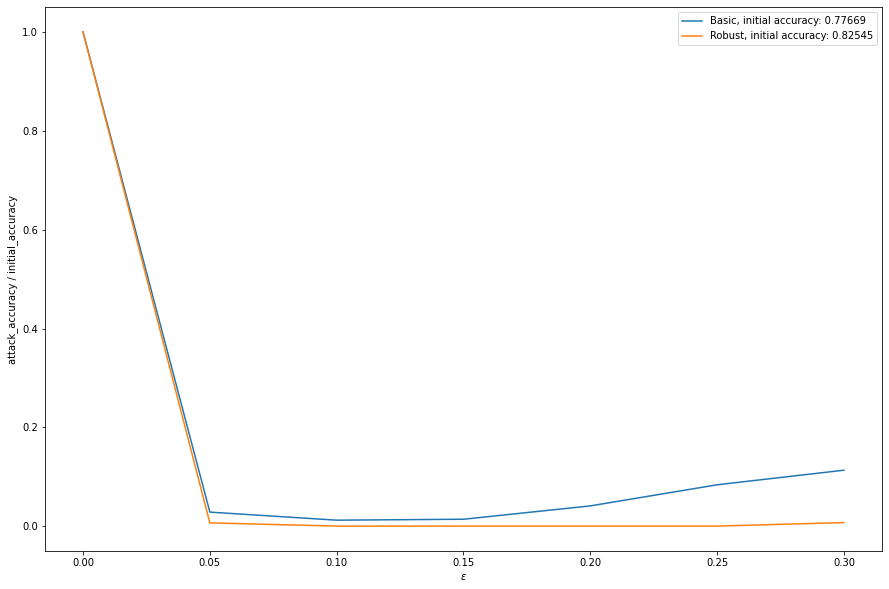

In [66]:
plt.figure(figsize=(15, 10))
plt.plot(epsilons, basic_model_accs / basic_model_accs[0], label="Basic, initial accuracy: " + str(round(basic_model_accs[0], 5)))
plt.plot(epsilons, robust_model_accs / robust_model_accs[0], label="Robust, initial accuracy: " + str(round(robust_model_accs[0], 5)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.legend()
plt.show()

In [36]:
basic_model_accs

array([0.77133106, 0.04339347, 0.02827889, 0.03217942, 0.03266699,
       0.05411994, 0.08386153])

In [37]:
robust_model_accs

array([0.8210629 , 0.047294  , 0.03607996, 0.04339347, 0.05802048,
       0.07849829, 0.09215017])